# Worked All OARC

## Setup

### Imports

First we do all of our imports. Ideally we import in alphabetical order, and I wish there was a way to generate `requirements.txt` from it directly.

I also detect if running on Google Colab as I need to import from here...

In [1]:
import os

if 'COLAB_GPU' in os.environ:
    %pip install maidenhead ipyleaflet ipywidgets pyhamtools matplotlib>=3.5.2
    from google.auth import default
    from google.colab import auth

import datetime
import gspread as gs
import ipywidgets as widgets
import json
import maidenhead as mh
import matplotlib
import numpy as np
import pandas as pd
import re
import requests
from ipyleaflet import AwesomeIcon, DivIcon, Map, basemaps, basemap_to_tiles, LayersControl, LayerGroup, Marker, MarkerCluster, Polyline
from IPython.display import HTML as HTML2
from ipywidgets import interact, interact_manual
from matplotlib import pyplot
from pyhamtools import LookupLib, Callinfo
from pyhamtools.locator import calculate_distance
if 'COLAB_GPU' in os.environ:
    %pip install matplotlib --upgrade

print('matplotlib: {}'.format(matplotlib.__version__))


matplotlib: 3.5.1


### Setup pyhamtools

Little bit of set up for DXCC cleaning

In [2]:
my_lookuplib = LookupLib(lookuptype='countryfile')
cic = Callinfo(my_lookuplib)

### Set up Google Sheet credentials

Some nasty little tricks needed here:

1. For local environment, we use a .json file in the parent so it won't be pushed to github
1. For Netlify deployment, we detect it by reading the Environment Variable `NETLIFY`
   1. Then we read all the env vars into a dictionary
   2. We have to replace all the `'\\n'` with `'\n'` as the extra `'\'` gets added
1. Then we get access to the Google Sheet

In [3]:
def create_keyfile_dict():
    variables_keys = {
       "type": os.getenv("TYPE"),
       "project_id": os.getenv("PROJECT_ID"),
       "private_key_id": os.getenv("PRIVATE_KEY_ID"),
       "private_key": os.getenv("PRIVATE_KEY").replace("\\n", "\n"),
       "client_email": os.getenv("CLIENT_EMAIL"),
       "client_id": os.getenv("CLIENT_ID"),
       "auth_uri": os.getenv("AUTH_URI"),
       "token_uri": os.getenv("TOKEN_URI"),
       "auth_provider_x509_cert_url": os.getenv("AUTH_PROVIDER_X509_CERT_URL"),
       "client_x509_cert_url": os.getenv("CLIENT_X509_CERT_URL")
    }
    return variables_keys
if os.environ.get('NETLIFY'):
    gc = gs.service_account_from_dict(create_keyfile_dict())
elif 'COLAB_GPU' in os.environ:
    auth.authenticate_user()
    creds, _ = default()
    gc = gs.authorize(creds)
else:
    gc = gs.service_account(filename='../workedalloarc-53ba91a71aa2.json')
sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1dpciJGykIvwxHWgWrw_KTVi10EisyUZ6cah962oaStI/edit?usp=sharing')
ws = sh.worksheet('Form responses 1')
sh2 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1n6HCnGL-5z9RSuMO7bu5Un3iND_H2TEmj7brkdfnl8c/edit?usp=sharing')
ws2 = sh2.worksheet('Map')

### Load all the records

Our assumption zero is that all the data is dirty and not to be trusted. Even validation isn't perfect.
So we load it in first.

We also make a dfclean into which we will create a 'clean' set of QSOs. We will generate a series of error rows too

In [4]:
df = pd.DataFrame(ws.get_all_records())
dfclean = df.copy()
csmap = pd.DataFrame(ws2.get_all_records())
df.head(10)
csmap.head(10)

,Alias,Base Callsign
0,M0SMU,M0SMU
1,M7SMU,M0SMU
2,M0SMU/P,M0SMU
3,2E0UMS,M0SMU
4,EI5IYB,EI5IYB
5,EI5IYB/P,EI5IYB
6,MQ0JQQ,M0JQQ
7,MQ0LKW,M0LKW
8,MQ0TZO,M0TZO
9,MW0TZO,M0TZO


## Cleaning up the data

### Get all rows in scope of contest

Our start datetime is 00:00 1 June 2022 and end is 23:59 30 Sept. All UTC

In [5]:
start_date = pd.Timestamp(datetime.date(2022, 5, 31))
end_date = pd.Timestamp(datetime.date(2022,9,1))
dfclean['UTC'] = pd.to_datetime(dfclean['QSO Datetime (UTC)'], format='%d/%m/%Y %H:%M:%S')
#print(dfclean.dtypes)
mask = dfclean['UTC'] > start_date
dfclean = dfclean.loc[mask]
dfclean
#dfcleantime=dfclean[dfclean.UTC.between('2022-06-01', '2022-06-02')]
#dftime = dfclean[dfclean.UTC.between('2022-1-6', '2022-10-9')]
#dftime = dfclean.query('UTC >= @start_date and UTC < @end_date')

,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,Any other details,UTC
12,01/06/2022 09:18:10,01/06/2022 08:17:00,M0SMU,MQ0JQQ,430 MHz (70cms),Digital Voice,,,OARC Digital Bridge,DMR -> UHF -> Hotspot -> Internet -> OARC Digi...,First!,2022-06-01 08:17:00
13,01/06/2022 14:26:12,01/06/2022 13:17:00,MQ0LKW,MQ0JQQ,7 MHz (40m),FT8,JO01,IO95,,,,2022-06-01 13:17:00
14,01/06/2022 14:27:10,01/06/2022 10:00:00,MQ0LKW,2M0IIG,7 MHz (40m),FT8,JO01,IO85,,,,2022-06-01 10:00:00
15,01/06/2022 15:45:24,01/06/2022 14:40:00,M0SMU,M0LTE,Discord,FT8,IO81,IO91,,FT8 via M4a / MP3 over Discord (Audacity / VLC...,,2022-06-01 14:40:00
16,01/06/2022 15:46:28,01/06/2022 10:00:00,2M0IIG,MQ0LKW,7 MHz (40m),FT8,IO85,JO01,,,,2022-06-01 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
626,15/07/2022 20:45:30,15/07/2022 19:44:00,M0LKW,EI5IYB,7 MHz (40m),FT8,JO01,IO63,,,,2022-07-15 19:44:00
627,15/07/2022 20:48:18,15/07/2022 19:44:00,EI5IYB,M0LKW,7 MHz (40m),FT8,IO63,JO01,,,,2022-07-15 19:44:00
628,15/07/2022 20:54:13,15/07/2022 18:55:00,EI5IYB,M0JQQ,7 MHz (40m),MFSK - JS8,IO63WE,IO95EC,,,,2022-07-15 18:55:00
629,15/07/2022 23:16:22,15/07/2022 21:01:00,EI5IYB,M0SMU,7 MHz (40m),FT8,IO63,IO81,,,,2022-07-15 21:01:00


### Callsigns

So the first job is to clean up the callsigns, you can't have a QSO without two valid callsigns!

I've found a good regex to split out a callsign into components (prefix, letters, number, letters, suffix), but as we will see later, that isn't enough to extract the DXCC from a callsign.

In [6]:
# Next we clean the callsigns up and find any prefix / suffix and the DXCC
regex = re.compile('^([A-Z0-9]+[\/])?([A-Z][0-9]|[A-Z]{1,2}|[0-9][A-Z])([0-9]|[0-9]+)([A-Z]+)([\/][A-Z0-9]+)?')
df['Your Callsign Clean'] = df['Your Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
df['Your DXCC'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[1]
df['Your Prefix'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[0]
df['Your Suffix'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[4]
df['Their Callsign Clean'] = df['Their Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
df['Their DXCC'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[1]
df['Their Prefix'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[0]
df['Their Suffix'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[4]
df.head(10)


,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,Any other details,Your Callsign Clean,Your DXCC,Your Prefix,Your Suffix,Their Callsign Clean,Their DXCC,Their Prefix,Their Suffix
0,26/04/2022 20:34:04,27/04/2022 12:23:00,M0SMU,M7SMU,144 MHz (2m),FM,IO81oj,IO81ql,EU-005,Not innovative at all,test,M0SMU,M,NaN,NaN,M7SMU,M,NaN,NaN
1,26/04/2022 20:34:35,19/04/2022 09:00:00,M0SMU,2E0UMS,7 MHz (40m),SSB,,,,,,M0SMU,M,NaN,NaN,2E0UMS,2E,NaN,NaN
2,26/04/2022 20:37:12,24/04/2021 11:00:00,2e0ggj,m0nvk,7 MHz (40m),SSB,io95fb,m0nvk home qth,,Ran one or two full courses :-),Am a good egg !,2E0GGJ,2E,NaN,NaN,M0NVK,M,NaN,NaN
3,26/04/2022 20:39:58,20/03/2022 19:31:00,mojqq,m0lte,7 MHz (40m),Olivia,io95ec,nk,,,,MOJQQ,NaN,NaN,NaN,M0LTE,M,NaN,NaN
4,26/04/2022 20:41:07,26/04/2022 15:30:00,m0jqq,m0smu,144 MHz (2m),DMR,none,none,,,,M0JQQ,M,NaN,NaN,M0SMU,M,NaN,NaN
5,26/04/2022 22:18:00,26/04/2022 22:04:00,M0SMU,2EØVCC/P,144 MHz (2m),SSB,,,,,,M0SMU,M,NaN,NaN,2E0VCC/P,2E,NaN,/P
6,27/04/2022 12:27:40,27/04/2022 12:24:00,EI5IYB /P,M0SMU,Gamma Wave,Telepathy93,IO63we,IO81oj,Brain Waves,Well...,Detailed details,EI5IYB/P,EI,NaN,/P,M0SMU,M,NaN,NaN
7,29/04/2022 11:28:11,28/04/2022 09:00:00,2E0UMS,M0OUK,144 MHz (2m),SSB,IO81oj,,,,,2E0UMS,2E,NaN,NaN,M0OUK,M,NaN,NaN
8,29/04/2022 23:14:57,28/04/2022 21:22:00,EI5IYB,TF2MSN,7 MHz (40m),FT8,,,,,,EI5IYB,EI,NaN,NaN,TF2MSN,TF,NaN,NaN
9,29/04/2022 23:18:41,29/04/2022 22:17:00,EI5IYB,IW9FRA,7 MHz (40m),FT8,IO63,JM68,,,,EI5IYB,EI,NaN,NaN,IW9FRA,IW,NaN,NaN


### Clean up callsigns in dfclean

Remove suffix and have suffix in another column (My Suffix, Their Suffix)

In [7]:
dfclean['Your Callsign'] = dfclean['Your Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
#df['Your DXCC'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[1]
dfclean['Your Prefix'] = dfclean['Your Callsign'].str.extract(regex, expand=True)[0]
dfclean['Your Suffix'] = dfclean['Your Callsign'].str.extract(regex, expand=True)[4]
dfclean['Their Callsign'] = dfclean['Their Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
#df['Their DXCC'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[1]
dfclean['Their Prefix'] = dfclean['Their Callsign'].str.extract(regex, expand=True)[0]
dfclean['Their Suffix'] = dfclean['Their Callsign'].str.extract(regex, expand=True)[4]
dfclean.head(10)

,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,Any other details,UTC,Your Prefix,Your Suffix,Their Prefix,Their Suffix
12,01/06/2022 09:18:10,01/06/2022 08:17:00,M0SMU,MQ0JQQ,430 MHz (70cms),Digital Voice,,,OARC Digital Bridge,DMR -> UHF -> Hotspot -> Internet -> OARC Digi...,First!,2022-06-01 08:17:00,NaN,NaN,NaN,NaN
13,01/06/2022 14:26:12,01/06/2022 13:17:00,MQ0LKW,MQ0JQQ,7 MHz (40m),FT8,JO01,IO95,,,,2022-06-01 13:17:00,NaN,NaN,NaN,NaN
14,01/06/2022 14:27:10,01/06/2022 10:00:00,MQ0LKW,2M0IIG,7 MHz (40m),FT8,JO01,IO85,,,,2022-06-01 10:00:00,NaN,NaN,NaN,NaN
15,01/06/2022 15:45:24,01/06/2022 14:40:00,M0SMU,M0LTE,Discord,FT8,IO81,IO91,,FT8 via M4a / MP3 over Discord (Audacity / VLC...,,2022-06-01 14:40:00,NaN,NaN,NaN,NaN
16,01/06/2022 15:46:28,01/06/2022 10:00:00,2M0IIG,MQ0LKW,7 MHz (40m),FT8,IO85,JO01,,,,2022-06-01 10:00:00,NaN,NaN,NaN,NaN
17,01/06/2022 16:22:16,01/06/2022 15:21:00,M0SMU,2M0OCC,430 MHz (70cms),Digital Voice,,,OARC Digital bridge,,,2022-06-01 15:21:00,NaN,NaN,NaN,NaN
18,01/06/2022 16:27:48,01/06/2022 15:21:00,2M0OCC,M0SMU,Internet,Digital Voice,,,OARC Digital bridge,Using echo link via computer,,2022-06-01 15:21:00,NaN,NaN,NaN,NaN
19,01/06/2022 16:30:43,01/06/2022 15:25:00,2M0OCC,2M0PVP,Internet,Digital Voice,IO86BC,IO88MX,OARC Digital bridge,,,2022-06-01 15:25:00,NaN,NaN,NaN,NaN
20,01/06/2022 16:31:52,01/06/2022 15:30:00,2M0PVP,2M0OCC,430 MHz (70cms),Digital Voice,IO88MX,IO86BC,OARC Digital bridge,,,2022-06-01 15:30:00,NaN,NaN,NaN,NaN
21,01/06/2022 18:14:37,01/06/2022 14:36:00,M0LTE,M0SMU,Discord,FT8,IO91,IO81,,FT8 via acoustically coupled voice notes sent ...,,2022-06-01 14:36:00,NaN,NaN,NaN,NaN


### Clean DXCC

We want to extract the DXCC for dfclean callsigns

In [8]:
def cleandxcc(callsign):
    '''returns the DXCC for a callsign'''
    try:
        ret = cic.get_country_name(callsign)
    except KeyError:
        ret = "N/A"
    return ret

def cleanituz(callsign):
    '''returns the DXCC for a callsign'''
    try:
        ret = cic.get_ituz(callsign)
    except KeyError:
        ret = "N/A"
    return ret

def cleancqz(callsign):
    '''returns the DXCC for a callsign'''
    try:
        ret = cic.get_cqz(callsign)
    except KeyError:
        ret = "N/A"
    return ret

def homecallsign(callsign):
    '''returns home callsign and strips prefix / suffix'''
    try:
        ret = cic.get_homecall(callsign)
    except KeyError:
        ret = 'N/A'
    return ret

print(cleandxcc('IW9AAB'))
print(cleandxcc('M7SMU'))
print(cleandxcc('EI5IYB/P'))
print(cleandxcc('MQ0JQQ'))
print(cic.is_valid_callsign('MQ0JQQ'))
print(cic.get_homecall('MW0TZO/P'))

dfclean['Your DXCC'] = dfclean['Your Callsign'].map(lambda x: cleandxcc(x))
dfclean['Their DXCC'] = dfclean['Their Callsign'].map(lambda x: cleandxcc(x))
dfclean['Your ITUZ'] = dfclean['Your Callsign'].map(lambda x: cleanituz(x))
dfclean['Their ITUZ'] = dfclean['Their Callsign'].map(lambda x: cleanituz(x))
dfclean['Your CQZ'] = dfclean['Your Callsign'].map(lambda x: cleancqz(x))
dfclean['Their CQZ'] = dfclean['Their Callsign'].map(lambda x: cleancqz(x))

dfclean

Sicily
England
Ireland
England
True
MW0TZO


,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,...,Your Prefix,Your Suffix,Their Prefix,Their Suffix,Your DXCC,Their DXCC,Your ITUZ,Their ITUZ,Your CQZ,Their CQZ
12,01/06/2022 09:18:10,01/06/2022 08:17:00,M0SMU,MQ0JQQ,430 MHz (70cms),Digital Voice,,,OARC Digital Bridge,DMR -> UHF -> Hotspot -> Internet -> OARC Digi...,...,NaN,NaN,NaN,NaN,England,England,27,27,14,14
13,01/06/2022 14:26:12,01/06/2022 13:17:00,MQ0LKW,MQ0JQQ,7 MHz (40m),FT8,JO01,IO95,,,...,NaN,NaN,NaN,NaN,England,England,27,27,14,14
14,01/06/2022 14:27:10,01/06/2022 10:00:00,MQ0LKW,2M0IIG,7 MHz (40m),FT8,JO01,IO85,,,...,NaN,NaN,NaN,NaN,England,Scotland,27,27,14,14
15,01/06/2022 15:45:24,01/06/2022 14:40:00,M0SMU,M0LTE,Discord,FT8,IO81,IO91,,FT8 via M4a / MP3 over Discord (Audacity / VLC...,...,NaN,NaN,NaN,NaN,England,England,27,27,14,14
16,01/06/2022 15:46:28,01/06/2022 10:00:00,2M0IIG,MQ0LKW,7 MHz (40m),FT8,IO85,JO01,,,...,NaN,NaN,NaN,NaN,Scotland,England,27,27,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,15/07/2022 20:45:30,15/07/2022 19:44:00,M0LKW,EI5IYB,7 MHz (40m),FT8,JO01,IO63,,,...,NaN,NaN,NaN,NaN,England,Ireland,27,27,14,14
627,15/07/2022 20:48:18,15/07/2022 19:44:00,EI5IYB,M0LKW,7 MHz (40m),FT8,IO63,JO01,,,...,NaN,NaN,NaN,NaN,Ireland,England,27,27,14,14
628,15/07/2022 20:54:13,15/07/2022 18:55:00,EI5IYB,M0JQQ,7 MHz (40m),MFSK - JS8,IO63WE,IO95EC,,,...,NaN,NaN,NaN,NaN,Ireland,England,27,27,14,14
629,15/07/2022 23:16:22,15/07/2022 21:01:00,EI5IYB,M0SMU,7 MHz (40m),FT8,IO63,IO81,,,...,NaN,NaN,NaN,NaN,Ireland,England,27,27,14,14


### Map aliases to base callsigns

In [9]:
dfclean['Your Home Callsign'] = dfclean['Your Callsign'].map(lambda x: homecallsign(x))
dfcleanalised = pd.merge(left=dfclean, right=csmap, left_on='Your Home Callsign', right_on='Alias', how='left')
dfcleanalised['Base Your Callsign'] = dfcleanalised['Base Callsign'].combine_first(dfcleanalised['Your Home Callsign'])
dfcleanalised = dfcleanalised.drop(['Base Callsign', 'Alias'], axis=1)
dfcleanalised

,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,...,Their Prefix,Their Suffix,Your DXCC,Their DXCC,Your ITUZ,Their ITUZ,Your CQZ,Their CQZ,Your Home Callsign,Base Your Callsign
0,01/06/2022 09:18:10,01/06/2022 08:17:00,M0SMU,MQ0JQQ,430 MHz (70cms),Digital Voice,,,OARC Digital Bridge,DMR -> UHF -> Hotspot -> Internet -> OARC Digi...,...,NaN,NaN,England,England,27,27,14,14,M0SMU,M0SMU
1,01/06/2022 14:26:12,01/06/2022 13:17:00,MQ0LKW,MQ0JQQ,7 MHz (40m),FT8,JO01,IO95,,,...,NaN,NaN,England,England,27,27,14,14,MQ0LKW,M0LKW
2,01/06/2022 14:27:10,01/06/2022 10:00:00,MQ0LKW,2M0IIG,7 MHz (40m),FT8,JO01,IO85,,,...,NaN,NaN,England,Scotland,27,27,14,14,MQ0LKW,M0LKW
3,01/06/2022 15:45:24,01/06/2022 14:40:00,M0SMU,M0LTE,Discord,FT8,IO81,IO91,,FT8 via M4a / MP3 over Discord (Audacity / VLC...,...,NaN,NaN,England,England,27,27,14,14,M0SMU,M0SMU
4,01/06/2022 15:46:28,01/06/2022 10:00:00,2M0IIG,MQ0LKW,7 MHz (40m),FT8,IO85,JO01,,,...,NaN,NaN,Scotland,England,27,27,14,14,2M0IIG,2M0IIG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,15/07/2022 20:45:30,15/07/2022 19:44:00,M0LKW,EI5IYB,7 MHz (40m),FT8,JO01,IO63,,,...,NaN,NaN,England,Ireland,27,27,14,14,M0LKW,M0LKW
615,15/07/2022 20:48:18,15/07/2022 19:44:00,EI5IYB,M0LKW,7 MHz (40m),FT8,IO63,JO01,,,...,NaN,NaN,Ireland,England,27,27,14,14,EI5IYB,EI5IYB
616,15/07/2022 20:54:13,15/07/2022 18:55:00,EI5IYB,M0JQQ,7 MHz (40m),MFSK - JS8,IO63WE,IO95EC,,,...,NaN,NaN,Ireland,England,27,27,14,14,EI5IYB,EI5IYB
617,15/07/2022 23:16:22,15/07/2022 21:01:00,EI5IYB,M0SMU,7 MHz (40m),FT8,IO63,IO81,,,...,NaN,NaN,Ireland,England,27,27,14,14,EI5IYB,EI5IYB


In [10]:
dfcleanalised['Their Home Callsign'] = dfcleanalised['Their Callsign'].map(lambda x: homecallsign(x))
dfcleanalised = pd.merge(left=dfcleanalised, right=csmap, left_on='Their Home Callsign', right_on='Alias', how='left')
dfcleanalised['Base Their Callsign'] = dfcleanalised['Base Callsign'].combine_first(dfcleanalised['Their Home Callsign'])
dfcleanalised = dfcleanalised.drop(['Base Callsign', 'Alias'], axis=1)
dfcleanalised

,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,...,Your DXCC,Their DXCC,Your ITUZ,Their ITUZ,Your CQZ,Their CQZ,Your Home Callsign,Base Your Callsign,Their Home Callsign,Base Their Callsign
0,01/06/2022 09:18:10,01/06/2022 08:17:00,M0SMU,MQ0JQQ,430 MHz (70cms),Digital Voice,,,OARC Digital Bridge,DMR -> UHF -> Hotspot -> Internet -> OARC Digi...,...,England,England,27,27,14,14,M0SMU,M0SMU,MQ0JQQ,M0JQQ
1,01/06/2022 14:26:12,01/06/2022 13:17:00,MQ0LKW,MQ0JQQ,7 MHz (40m),FT8,JO01,IO95,,,...,England,England,27,27,14,14,MQ0LKW,M0LKW,MQ0JQQ,M0JQQ
2,01/06/2022 14:27:10,01/06/2022 10:00:00,MQ0LKW,2M0IIG,7 MHz (40m),FT8,JO01,IO85,,,...,England,Scotland,27,27,14,14,MQ0LKW,M0LKW,2M0IIG,2M0IIG
3,01/06/2022 15:45:24,01/06/2022 14:40:00,M0SMU,M0LTE,Discord,FT8,IO81,IO91,,FT8 via M4a / MP3 over Discord (Audacity / VLC...,...,England,England,27,27,14,14,M0SMU,M0SMU,M0LTE,M0LTE
4,01/06/2022 15:46:28,01/06/2022 10:00:00,2M0IIG,MQ0LKW,7 MHz (40m),FT8,IO85,JO01,,,...,Scotland,England,27,27,14,14,2M0IIG,2M0IIG,MQ0LKW,M0LKW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,15/07/2022 20:45:30,15/07/2022 19:44:00,M0LKW,EI5IYB,7 MHz (40m),FT8,JO01,IO63,,,...,England,Ireland,27,27,14,14,M0LKW,M0LKW,EI5IYB,EI5IYB
615,15/07/2022 20:48:18,15/07/2022 19:44:00,EI5IYB,M0LKW,7 MHz (40m),FT8,IO63,JO01,,,...,Ireland,England,27,27,14,14,EI5IYB,EI5IYB,M0LKW,M0LKW
616,15/07/2022 20:54:13,15/07/2022 18:55:00,EI5IYB,M0JQQ,7 MHz (40m),MFSK - JS8,IO63WE,IO95EC,,,...,Ireland,England,27,27,14,14,EI5IYB,EI5IYB,M0JQQ,M0JQQ
617,15/07/2022 23:16:22,15/07/2022 21:01:00,EI5IYB,M0SMU,7 MHz (40m),FT8,IO63,IO81,,,...,Ireland,England,27,27,14,14,EI5IYB,EI5IYB,M0SMU,M0SMU


### Cleaning up locators

8 char max

In [11]:
def locatorparse(cell):
    charstr = ''
    for char in cell:
        if char.isalpha():
            charstr = charstr + 'a'
        elif char.isnumeric():
            charstr = charstr + '0'
        else:
            charstr = charstr + 'X'
    return (charstr)

def maiden_isvalid(mhlocator):
    '''returns True for a valid Maidenhead locator'''
    mhlocator = mhlocator.upper()
    if len(mhlocator) % 2 == 1:
        return (False)
    if len(mhlocator) > 12:
        return (False)
    if ord(mhlocator[0]) > ord('R') or ord(mhlocator[0]) < ord('A'):
        return (False)
    if ord(mhlocator[1]) > ord('R') or ord(mhlocator[1]) < ord('A'):
        return (False)
    if ord(mhlocator[2]) > ord('9') or ord(mhlocator[2]) < ord('0'):
        return (False)
    if ord(mhlocator[3]) > ord('9') or ord(mhlocator[3]) < ord('0'):
        return (False)
    if len(mhlocator) > 4:
        if ord(mhlocator[4]) > ord('R') or ord(mhlocator[4]) < ord('A'):
            return (False)
        if ord(mhlocator[5]) > ord('R') or ord(mhlocator[5]) < ord('A'):
            return (False)
    if len(mhlocator) > 6:
        if ord(mhlocator[6]) > ord('9') or ord(mhlocator[6]) < ord('0'):
            return (False)
        if ord(mhlocator[7]) > ord('9') or ord(mhlocator[7]) < ord('0'):
            return (False)       
    if len(mhlocator) > 8:
        if ord(mhlocator[8]) > ord('9') or ord(mhlocator[8]) < ord('0'):
            return (False)
        if ord(mhlocator[9]) > ord('9') or ord(mhlocator[9]) < ord('0'):
            return (False)  
    if len(mhlocator) > 10:
        if ord(mhlocator[10]) > ord('9') or ord(mhlocator[10]) < ord('0'):
            return (False)
        if ord(mhlocator[11]) > ord('9') or ord(mhlocator[11]) < ord('0'):
            return (False)  
    return (True)

def maiden_errors(mhlocator):
    '''returns True for a valid Maidenhead locator'''
    mhlocator = mhlocator.upper()
    errstr = ''
    if len(mhlocator) % 2 == 1:
        errstr = errstr + 'odd'
    if len(mhlocator) > 12:
        errstr = errstr + 'Long'
    if ord(mhlocator[0]) > ord('R') or ord(mhlocator[0]) < ord('A'):
        errstr = errstr + '1'
    if ord(mhlocator[1]) > ord('R') or ord(mhlocator[1]) < ord('A'):
        errstr = errstr + '2'
    if ord(mhlocator[2]) > ord('9') or ord(mhlocator[2]) < ord('0'):
        errstr = errstr + '3'
    if ord(mhlocator[3]) > ord('9') or ord(mhlocator[3]) < ord('0'):
        errstr = errstr + '4'
    if len(mhlocator) > 4:
        if ord(mhlocator[4]) > ord('R') or ord(mhlocator[4]) < ord('A'):
            errstr = errstr + '5'
        if ord(mhlocator[5]) > ord('R') or ord(mhlocator[5]) < ord('A'):
            errstr = errstr + '6'
    if len(mhlocator) > 6:
        if ord(mhlocator[6]) > ord('9') or ord(mhlocator[6]) < ord('0'):
            errstr = errstr + '7'
        if ord(mhlocator[7]) > ord('9') or ord(mhlocator[7]) < ord('0'):
            errstr = errstr + '8'       
    if len(mhlocator) > 8:
        if ord(mhlocator[8]) > ord('9') or ord(mhlocator[8]) < ord('0'):
            errstr = errstr + '9'
        if ord(mhlocator[9]) > ord('9') or ord(mhlocator[9]) < ord('0'):
            errstr = errstr + 'A' 
    if len(mhlocator) > 10:
        if ord(mhlocator[10]) > ord('9') or ord(mhlocator[10]) < ord('0'):
            errstr = errstr + 'B'
        if ord(mhlocator[11]) > ord('9') or ord(mhlocator[11]) < ord('0'):
            rerrstr = errstr + 'C'  
    return (errstr)

dfcleanalised['Locator Sent'] = dfcleanalised['Locator Sent'].astype('string').apply(lambda x: x.strip() if type(x)==str else x)
dfcleanalised['Locator Received'] = dfcleanalised['Locator Received'].astype('string').apply(lambda x: x.strip() if type(x)==str else x)
dfcleanalised['Locator Sent'] = dfcleanalised['Locator Sent'].astype('string')
dfcleanalised['Locator Received'] = dfcleanalised['Locator Received'].astype('string')
#print(dfcleanalised.dtypes)
# locsent = dfcleanalised['Locator Sent'].apply(locatorparse)
# locrec = dfcleanalised['Locator Received'].apply(locatorparse)
# dfcleanalised[['Locator Sent','Locator Received']]
print('IO83xm: ' + str(maiden_isvalid('IO83xm')))
print('IO81oj: ' + str(maiden_isvalid('IO81oj')))
print('IW81oj: ' + str(maiden_errors('Iw81oj')))





IO83xm: False
IO81oj: True
IW81oj: 2


## Example Leaderboards

### Most QSOs made

2M0MQN      1
K2EXE       1
MI7EMG      1
MM1STK      1
G5LUX       1
2E0HPH      1
DO1TBE      1
M0UKF       1
2E0CPX      2
G4SEB       3
M1MBZ       3
MM0MFZ      4
EI6IKB      4
2E0EMO      4
2E1PKY      6
EI8ICB      6
G8CAP       7
EI8ILB      7
M0LKW       8
W7EWK       8
G6AWK       9
G0TRT      11
M0GZP      14
M5JFS      14
M7GET      15
2M0PVP     16
2M0OCC     16
M0LTE      16
G6NWF      18
G5NLD      26
M0JQQ      35
G5HOW      36
M0TZO      39
M0NVK      41
2M0IIG     41
M0SMU      81
EI5IYB    121
Name: Base Your Callsign, dtype: int64

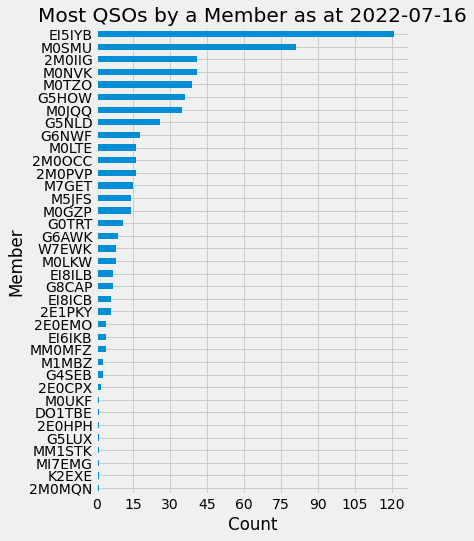

In [12]:
from matplotlib.ticker import MaxNLocator
today = datetime.datetime.now().strftime("%Y-%m-%d")
with pyplot.style.context(('fivethirtyeight')):
    mostqsos = dfcleanalised['Base Your Callsign'].value_counts().sort_values().plot(kind='barh', figsize=(5,8))
    mostqsos.set_title('Most QSOs by a Member as at ' + today)
    mostqsos.set_xlabel('Count')
    mostqsos.set_ylabel('Member')
    mostqsos.xaxis.set_major_locator(MaxNLocator(integer=True))
    if 'COLAB_GPU' not in os.environ:
        mostqsos.figure.savefig('images/mostqsos.png', bbox_inches='tight')
mostqsost = dfcleanalised['Base Your Callsign'].value_counts().sort_values()
mostqsost

### Most members worked

How many individual members have been worked?

,Base Their Callsign
Base Your Callsign,
2E0EMO,1
2E0HPH,1
MI7EMG,1
2M0MQN,1
M0UKF,1
DO1TBE,1
K2EXE,1
MM1STK,1
G5LUX,1


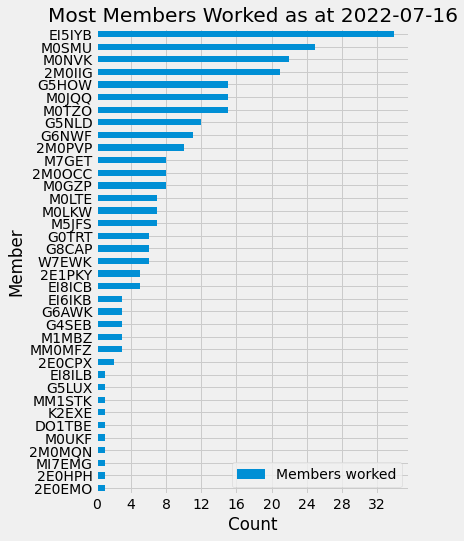

In [13]:
with pyplot.style.context(('fivethirtyeight')):
    mostmemworked = dfcleanalised[['Base Your Callsign','Base Their Callsign']]
    mostmemworked = mostmemworked.drop_duplicates().groupby('Base Your Callsign').count().sort_values(by='Base Their Callsign').plot(kind='barh', figsize=(5,8))
    mostmemworked.set_xlabel('Count')
    mostmemworked.set_title('Most Members Worked as at ' + today)
    mostmemworked.set_ylabel('Member')
    mostmemworked.xaxis.set_major_locator(MaxNLocator(integer=True))
    mostmemworked.legend(['Members worked'])
    if 'COLAB_GPU' not in os.environ:
        mostmemworked.figure.savefig('images/mostmemworked.png', bbox_inches='tight')
mostmemworkedt = dfcleanalised[['Base Your Callsign','Base Their Callsign']].drop_duplicates().groupby('Base Your Callsign').count().sort_values(by='Base Their Callsign')
mostmemworkedt

### Worked by most Members

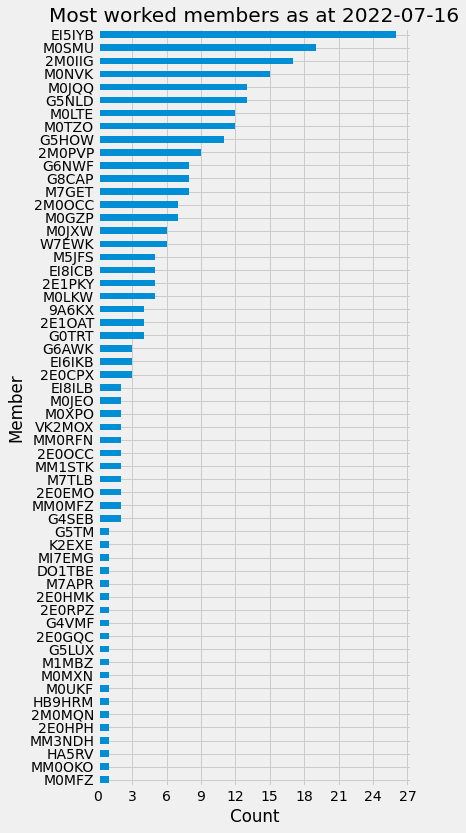

In [14]:
with pyplot.style.context(('fivethirtyeight')):
    workedmost = dfcleanalised[['Base Their Callsign', 'Base Your Callsign']].drop_duplicates()['Base Their Callsign'].value_counts().sort_values().plot(kind='barh', figsize=(5,13))
    workedmost.set_title('Most worked members as at ' + today)
    workedmost.set_xlabel('Count')
    workedmost.set_ylabel('Member')
    workedmost.xaxis.set_major_locator(MaxNLocator(integer=True))
    if 'COLAB_GPU' not in os.environ:
        workedmost.figure.savefig('images/mostworkedmem.png', bbox_inches='tight')
#workedmostt = dfcleanalised[['Base Their Callsign', 'Base Your Callsign']].drop_duplicates()['Base Their Callsign'].value_counts()
#workedmostt

### Most DXCC worked

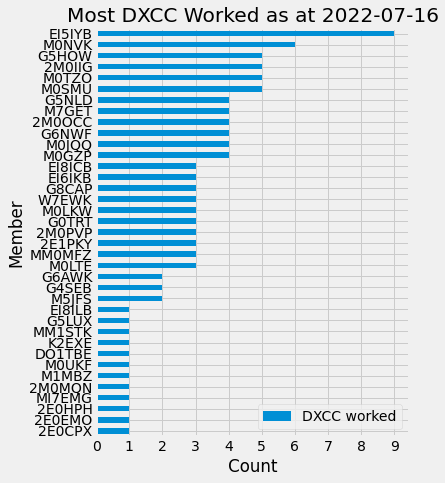

In [15]:
with pyplot.style.context(('fivethirtyeight')):
    mostdxccworked = dfcleanalised[['Base Your Callsign','Their DXCC']]
    mostdxccworked = mostdxccworked.drop_duplicates().groupby('Base Your Callsign').count().sort_values(by='Their DXCC').plot(kind='barh', figsize=(5,7))
    mostdxccworked.set_xlabel('Count')
    mostdxccworked.set_title('Most DXCC Worked as at ' + today)
    mostdxccworked.set_ylabel('Member')
    mostdxccworked.xaxis.set_major_locator(MaxNLocator(integer=True))
    mostdxccworked.legend(['DXCC worked'])
    if 'COLAB_GPU' not in os.environ:
        mostdxccworked.figure.savefig('images/mostdxcc.png', bbox_inches='tight')
#mostdxccworkedt = dfcleanalised[['Base Your Callsign','Their DXCC']].drop_duplicates().groupby('Base Your Callsign').count().sort_values(by='Their DXCC', ascending=False)
#mostdxccworkedt

## Example interaction

### Show 'my' QSOs

Note this is disabled in Netlify (as it doesn't work...)

In [16]:
if os.environ.get('NETLIFY'):
    print("Sadly we can't do interactivity in Netlify environment - I need to find a work around")
else:
    @interact
    def show_my_QSO(Callsign = dfcleanalised['Base Your Callsign'].unique()):
        return dfcleanalised.loc[dfcleanalised['Base Your Callsign'].values==Callsign]

interactive(children=(Dropdown(description='Callsign', options=('M0SMU', 'M0LKW', '2M0IIG', '2M0OCC', '2M0PVP'…

### Show QSOs by Band and Mode

In [17]:
if os.environ.get('NETLIFY'):
    print("Sadly we can't do interactivity in Netlify environment - I need to find a work around")
else:
    @interact
    def show_by_band_mode(Band = dfcleanalised['Band'].unique(), Mode = dfcleanalised['Mode'].unique()):
        return dfcleanalised.loc[(dfcleanalised['Band'].values==Band) & (dfcleanalised['Mode'].values==Mode)]

interactive(children=(Dropdown(description='Band', options=('430 MHz (70cms)', '7 MHz (40m)', 'Discord', 'Inte…

### My QSOs by Band Chart

In [18]:
def my_fmt(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

with pyplot.style.context(('fivethirtyeight')):
    @interact
    def myqsoplot(callsign = sorted(dfcleanalised['Base Your Callsign'].unique())):
        return dfcleanalised.loc[(dfcleanalised['Base Your Callsign'].values==callsign)]['Band'].value_counts().plot(kind='pie', figsize=(5,5), autopct=my_fmt(dfcleanalised.loc[(dfcleanalised['Base Your Callsign'].values==callsign)]['Band'].value_counts().values), title='My (' + callsign + ') QSOs by Band as at ' + today).yaxis.set_visible(False)

interactive(children=(Dropdown(description='callsign', options=('2E0CPX', '2E0EMO', '2E0HPH', '2E1PKY', '2M0II…

### My QSOs by Mode Chart

In [19]:
def my_fmt(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

with pyplot.style.context(('fivethirtyeight')):
    @interact
    def myqsoplot(callsign = sorted(dfcleanalised['Base Your Callsign'].unique())):
        return dfcleanalised.loc[(dfcleanalised['Base Your Callsign'].values==callsign)]['Mode'].value_counts().plot(kind='pie', figsize=(5,7), autopct=my_fmt(dfcleanalised.loc[(dfcleanalised['Base Your Callsign'].values==callsign)]['Mode'].value_counts().values), title='My (' + callsign + ') QSOs by Mode as at ' + today).yaxis.set_visible(False)

interactive(children=(Dropdown(description='callsign', options=('2E0CPX', '2E0EMO', '2E0HPH', '2E1PKY', '2M0II…

### My QSOs Map

In [20]:
# if os.environ.get('NETLIFY'):
#     print("Sadly we can't do interactivity in Netlify environment - I need to find a work around")
# else:
#     @interact
#     def showmyQSOmap(Callsign = dfcleanalised['Base Your Callsign'].unique()):
#         return dfcleanalised.loc[dfcleanalised['Base Your Callsign'].values==Callsign]
# myqsolines = []
# myqsomap = showmyQSOmap('M0SMU')
# myqsomap.drop_duplicates().values
# lines = []
# for row in myqsomap.drop_duplicates().values:
#     if (row[0][:2].isalpha() & row[1][:2].isalpha()):
#         line = [[mh.to_location(row[0], center=True)[0],mh.to_location(row[0], center=True)[1]],[mh.to_location(row[1], center=True)[0],mh.to_location(row[1], center=True)[1]]]
#         lines.append(line)
#     elif row[0][:1].isnumeric():
#         line = [row[0].split(',')[0],row[0].split(',')[1]], [row[1].split(',')[0],row[1].split(',')[1]]
#         lines.append(line)

# linelayer = Polyline(locations=lines, color="green", fill=False)
# mymap = Map(basemap=basemaps.Stamen.Toner, center = (54, -2), zoom =5)
# mymap.add_layer(linelayer)
# mymap.layout.height='700px'
# mymap.save('maps/myQSOs.html', title='QSO Locations')
# mymap

### Who have I worked?

In [21]:
if os.environ.get('NETLIFY'):
    print("Sadly we can't do interactivity in Netlify environment - I need to find a work around")
else:
    @interact
    def show_who_I_worked(Callsign = dfcleanalised['Base Your Callsign'].unique()):
        whoiworked = dfcleanalised[['Base Your Callsign', 'Base Their Callsign', 'UTC']]
        whoiworked = whoiworked.loc[whoiworked['Base Your Callsign'].values==Callsign].groupby('Base Their Callsign')['UTC'].max().sort_values()
        return whoiworked.to_frame().rename(columns={'UTC': 'Last Worked'})

interactive(children=(Dropdown(description='Callsign', options=('M0SMU', 'M0LKW', '2M0IIG', '2M0OCC', '2M0PVP'…

### Who could I work?

Our criteria is that they have logged or been logged but we haven't worked or been worked by them

In [22]:
whoicouldwork = pd.concat([dfcleanalised['Base Your Callsign'], dfcleanalised['Base Their Callsign']]).unique()
whoicouldwork

array(['M0SMU', 'M0LKW', '2M0IIG', '2M0OCC', '2M0PVP', 'M0LTE', 'M0NVK',
       'M0JQQ', 'EI5IYB', 'G5HOW', 'MM1STK', '2E0HPH', 'G6AWK', 'M0GZP',
       'G4SEB', 'G5NLD', 'EI6IKB', 'M0TZO', '2E0EMO', 'G0TRT', 'W7EWK',
       'M7GET', 'MM0MFZ', 'M0UKF', '2M0MQN', 'G8CAP', '2E1PKY', 'G6NWF',
       'EI8ILB', 'EI8ICB', 'G5LUX', '2E0CPX', 'MI7EMG', 'K2EXE', 'M5JFS',
       'M1MBZ', 'DO1TBE', '2E0RPZ', '2E0OCC', '2E1OAT', 'G4VMF', 'M0MFZ',
       '2E0HMK', 'HB9HRM', 'M0JEO', '9A6KX', 'M7TLB', 'MM0OKO', 'M0JXW',
       'VK2MOX', 'M0MXN', '2E0GQC', 'M0XPO', 'M7APR', 'MM3NDH', 'MM0RFN',
       'G5TM', 'HA5RV'], dtype=object)

## Bands and Modes

### QSOs by Band


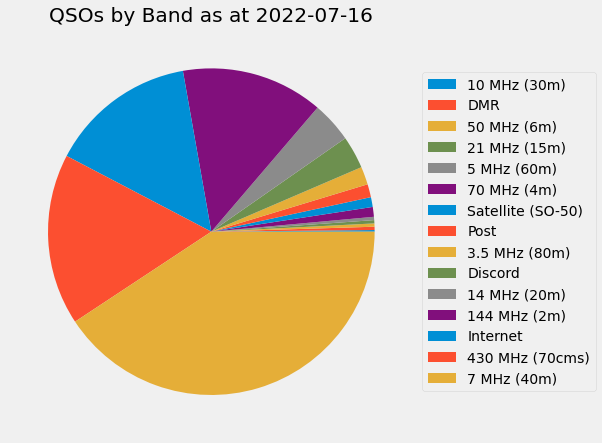

In [23]:
with pyplot.style.context(('fivethirtyeight')):
    bandplot = dfcleanalised['Band'].value_counts().sort_values().plot.pie(labeldistance=None, figsize=(9,7))
    bandplot.set_title('QSOs by Band as at ' + today)
    bandplot.yaxis.set_visible(False)
    bandplot.legend(bbox_to_anchor=(1,0.5), loc="center left")
    if 'COLAB_GPU' not in os.environ:
        bandplot.figure.savefig('images/qsobyband.png', bbox_inches='tight')
#bandplott = dfcleanalised['Band'].value_counts().sort_values()
#bandplott

### Most Bands Worked

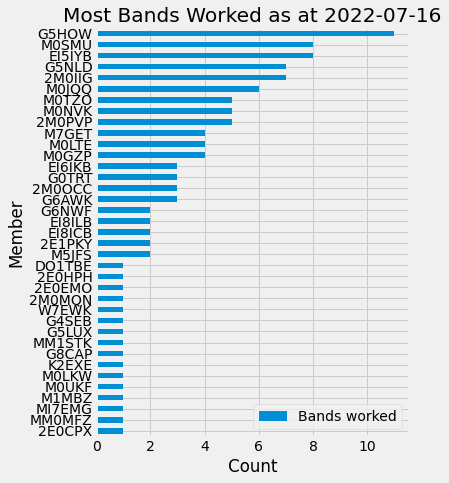

In [24]:
with pyplot.style.context(('fivethirtyeight')):
    mostbandworked = dfcleanalised[['Base Your Callsign', 'Band']].drop_duplicates()
    mostbandworked = mostbandworked[['Base Your Callsign', 'Band']].groupby('Base Your Callsign').count().sort_values(by='Band').plot(kind='barh', figsize=(5,7))
    mostbandworked.set_xlabel('Count')
    mostbandworked.set_title('Most Bands Worked as at ' + today)
    mostbandworked.set_ylabel('Member')
    mostbandworked.xaxis.set_major_locator(MaxNLocator(integer=True))
    mostbandworked.legend(['Bands worked'])
    if 'COLAB_GPU' not in os.environ:
        mostbandworked.figure.savefig('images/mostbandsworked.png', bbox_inches='tight')
# mostbandworkedt = dfcleanalised[['Base Your Callsign','Band']][dfcleanalised['Base Your Callsign']=='G5NLD'].drop_duplicates()
# mostbandworkedt

### QSOs by Mode

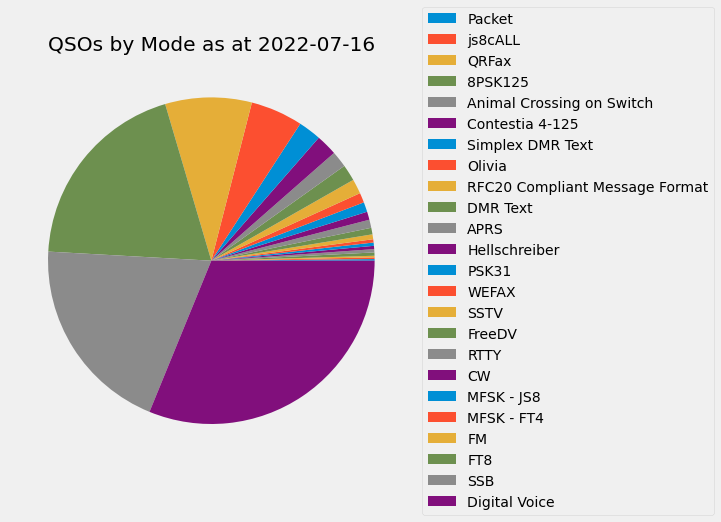

In [25]:
with pyplot.style.context(('fivethirtyeight')):
    modeplot = dfcleanalised['Mode'].value_counts().sort_values().plot.pie(labeldistance=None, figsize=(9,7))
    modeplot.set_title('QSOs by Mode as at ' + today)
    modeplot.yaxis.set_visible(False)
    modeplot.legend(bbox_to_anchor=(1,0.5), loc="center left")
    if 'COLAB_GPU' not in os.environ:
        modeplot.figure.savefig('images/qsobymode.png', bbox_inches='tight')
#modeplott = dfcleanalised['Mode'].value_counts().sort_values()
#modeplott

### Most modes worked

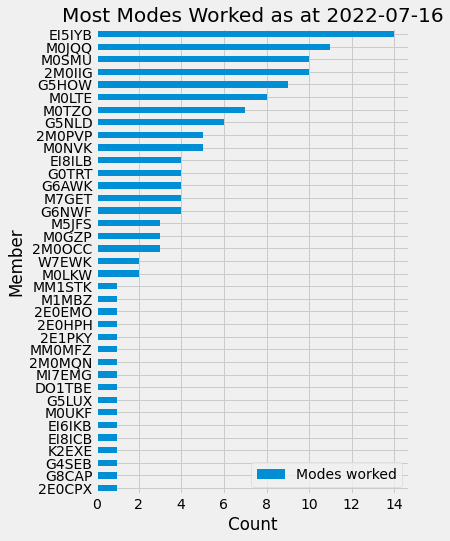

In [26]:
with pyplot.style.context(('fivethirtyeight')):
    mostmodesworked = dfcleanalised[['Base Your Callsign', 'Mode']].drop_duplicates()
    mostmodesworked = mostmodesworked[['Base Your Callsign', 'Mode']].groupby('Base Your Callsign').count().sort_values(by='Mode').plot(kind='barh', figsize=(5,8))
    mostmodesworked.set_xlabel('Count')
    mostmodesworked.set_title('Most Modes Worked as at ' + today)
    mostmodesworked.set_ylabel('Member')
    mostmodesworked.xaxis.set_major_locator(MaxNLocator(integer=True))
    mostmodesworked.legend(['Modes worked'])
    if 'COLAB_GPU' not in os.environ:
        mostmodesworked.figure.savefig('images/mostmodesworked.png', bbox_inches='tight')
# mostmodesworkedt = dfcleanalised[['Base Your Callsign','Mode']][dfcleanalised['Base Your Callsign']=='G5HOW']
# mostmodesworkedt

## Mapping

### Grids activated by members

In [27]:
from ipyleaflet import Popup
from ipywidgets import HTML
dfcleanalised['Locator Sent'] = dfcleanalised['Locator Sent'].str.upper()
locators = dfcleanalised[['Locator Sent', 'Base Your Callsign']].drop_duplicates()
Test_map = Map(basemap=basemaps.Stamen.Toner, center = [54, -2], zoom = 5, scroll_wheel_zoom=True)
for i,j in locators.values:
    if i[:2].upper().isalpha():
        marker = Marker(draggable=False, location=(mh.to_location(i, center=True)[0], mh.to_location(i, center=True)[1]))
        message = HTML(value="%s (%s)"%(j, i))
        marker.popup = message
        Test_map.add_layer(marker)
    elif i[:1].isnumeric():
        marker = Marker(draggable=False, location=(i.split(',')[0], i.split(',')[1]))
        message = HTML(value="%s (%s)"%(j, i))
        marker.popup = message
        Test_map.add_layer(marker)
Test_map.layout.height='700px'
if 'COLAB_GPU' not in os.environ:
    Test_map.save('maps/locations.html', title='Member Locations')
Test_map


Map(center=[54, -2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

### Lines to show QSOs

In [28]:

dfqso = dfcleanalised[['Locator Sent', 'Locator Received']]
dfqso.drop_duplicates().values
lines = []
for row in dfqso.drop_duplicates().values:
    if (row[0][:2].isalpha() & row[1][:2].isalpha()):
        line = [[mh.to_location(row[0][:8], center=True)[0],mh.to_location(row[0][:8], center=True)[1]],[mh.to_location(row[1][:8], center=True)[0],mh.to_location(row[1][:8], center=True)[1]]]
        lines.append(line)
    elif row[0][:1].isnumeric():
        line = [row[0].split(',')[0],row[0].split(',')[1]], [row[1].split(',')[0],row[1].split(',')[1]]
        lines.append(line)

linelayer = Polyline(locations=lines, color="green", fill=False)
m = Map(basemap=basemaps.Stamen.Toner, center = (54, -2), zoom =5, scroll_wheel_zoom=True)
m.add_layer(linelayer)
m.layout.height='700px'
if 'COLAB_GPU' not in os.environ:
    m.save('maps/QSOs.html', title='QSO Locations')
m

Map(center=[54, -2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

### 'RF' QSOs only

We exclude anything that isn't RF and anything tagged as Digital Voice. I'm aware this would remove any simplex DMR, but since no-one has done that yet... I'll live with it.

In [29]:
rfqso = dfcleanalised[['Locator Sent', 'Locator Received']][(dfcleanalised['Mode'] != 'Digital Voice') & (~dfcleanalised['Band'].isin(['Internet', 'Discord']))]
rfqso.drop_duplicates().values
lines = []
for row in rfqso.drop_duplicates().values:
    if (row[0][:2].isalpha() & row[1][:2].isalpha()):
        line = [[mh.to_location(row[0], center=True)[0],mh.to_location(row[0], center=True)[1]],[mh.to_location(row[1], center=True)[0],mh.to_location(row[1], center=True)[1]]]
        lines.append(line)
    elif row[0][:1].isnumeric():
        line = [row[0].split(',')[0],row[0].split(',')[1]], [row[1].split(',')[0],row[1].split(',')[1]]
        lines.append(line)
linelayer = Polyline(locations=lines, color="green", fill=False)
rfmap = Map(basemap=basemaps.Stamen.Toner, center = (54, -2), zoom =5, scroll_wheel_zoom=True)
rfmap.add_layer(linelayer)
rfmap.layout.height='700px'
if 'COLAB_GPU' not in os.environ:
    rfmap.save('maps/RFQSOs.html', title='RF QSO Locations')
rfmap

Map(center=[54, -2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

### SOTA Summits Activated or chased

In [30]:
# Workaround for cleaning the icon background (must be on a separate cell):
HTML2("""<style>
.leaflet-div-icon { background-color: transparent; border-color: transparent }
</style>""")
icon1 = AwesomeIcon(
    name='chevron-up',
    marker_color='green',
    icon_color='black',
    spin=False
)
icon2 = DivIcon(
    html='''<svg version="1.1"
	 id="svg4619" inkscape:version="0.91 r13725" sodipodi:docname="mountain-15.svg" xmlns:cc="http://creativecommons.org/ns#" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd" xmlns:svg="http://www.w3.org/2000/svg"
	 xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px" width="32px" height="32px"
	 viewBox="0 0 15 15" style="enable-background:new 0 0 32 32;" xml:space="preserve">
<path id="path5571" inkscape:connector-curvature="0" sodipodi:nodetypes="sccssssccsccccccccc" d="M7.5,2C7.2,2,7.1,2.2,6.9,2.4
	l-5.8,9.5C1,12,1,12.2,1,12.3C1,12.8,1.4,13,1.7,13h11.6c0.4,0,0.7-0.2,0.7-0.7c0-0.2,0-0.2-0.1-0.4L8.2,2.4C8,2.2,7.8,2,7.5,2z
	 M7.5,3.5L10.8,9H10L8.5,7.5L7.5,9l-1-1.5L5,9H4.1L7.5,3.5z"/>
</svg>''',
     icon_color = 'green',
     icon_size = (32,32)
)
icon3 = AwesomeIcon(
    name='home',
    marker_color='green',
    icon_color='black',
    spin=False
)

In [31]:
dfcleanalised['Locator Sent'] = dfcleanalised['Locator Sent'].str.upper()
dfcleanalised['Locator Received'] = dfcleanalised['Locator Received'].str.upper()
sotalocators = dfcleanalised[['Locator Sent', 'Locator Received', 'Base Your Callsign', 'Base Their Callsign', 'SOTA / IOAT / Sat / Network information']][dfcleanalised['SOTA / IOAT / Sat / Network information'].str.contains('\-', regex=True)]
sotalocators = sotalocators[sotalocators['SOTA / IOAT / Sat / Network information'].str.contains('/', regex=True)].drop_duplicates()
sotalocators = sotalocators[sotalocators['SOTA / IOAT / Sat / Network information'].str.contains('HEMA', regex=True)==False]
sotalocators['Distance'] = sotalocators.apply(lambda row: calculate_distance(row['Locator Sent'], row['Locator Received']), axis=1)
sotamap = Map(basemap=basemaps.Stamen.Toner, center = [54, -2], zoom = 5, scroll_wheel_zoom=True)
for i,j,k,l,m,n in sotalocators.values:
    url = ("https://api2.sota.org.uk/api/summits/" + m)
    sotasummit = requests.request("GET", url)
    response = sotasummit.json()   
    if i[:6] == response['locator'].upper(): # we are the activator
        activator = True
        linecolor = 'red'
    else: # we are chasing
        activator = False
        linecolor = 'green'
    if i[:2].upper().isalpha():
        qsoline = [[mh.to_location(i, center=True)[0], mh.to_location(i, center=True)[1]], [mh.to_location(j, center=True)[0], mh.to_location(j, center=True)[1]]]
        message = HTML(value="%s > %s<br />(%s > %s)<br />Distance %skm"%(k, l, i, j, round(n, 2)))
        if activator:
            markermessage = HTML(value="%s (%s)"%(l, j) )
            marker = Marker(draggable=False, icon=icon3, location=(mh.to_location(j, center=True)[0], mh.to_location(j, center=True)[1]), popup=markermessage)
            sotamap.add_layer(marker)
        else:
            markermessage = HTML(value="%s (%s)"%(k, i) )
            marker = Marker(draggable=False, icon=icon3, location=(mh.to_location(i, center=True)[0], mh.to_location(i, center=True)[1]), popup=markermessage)
            sotamap.add_layer(marker)
    elif i[:1].isnumeric():
        qsoline = [[i.split(',')[0], i.split(',')[1]],[j.split(',')[0], j.split(',')[1]]]
        message = HTML(value="%s > %s<br />(%s > %s)<br />Distance %skm"%(k, l, i, j, round(n, 2)))
    linelayer = Polyline(locations=qsoline, color=linecolor, fill=False, popup=message)
    sotamap.add_layer(linelayer)
for summit in sotalocators['SOTA / IOAT / Sat / Network information'].drop_duplicates():
    url = ("https://api2.sota.org.uk/api/summits/" + summit)
    sotasummit = requests.request("GET", url)
    response = sotasummit.json()
    marker = Marker(draggable=False, icon=icon1, location=(response['latitude'], response['longitude']))
    marker.popup = HTML(value=response['summitCode'])
    sotamap.add_layer(marker)
sotamap.layout.height='700px'
if 'COLAB_GPU' not in os.environ:
    sotamap.save('maps/SOTAmap.html', title='SOTA QSOs')
sotamap

Map(center=[54, -2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

## Stats by day

### QSOs by day

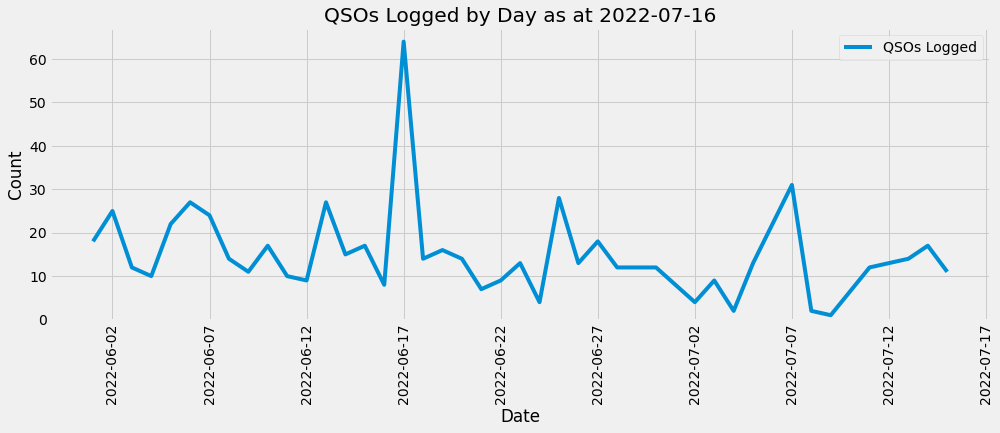

In [32]:
with pyplot.style.context(('fivethirtyeight')):
    daybyday = dfcleanalised[['UTC', 'Base Your Callsign']]
    daybyday = daybyday.set_index('UTC')
    daybyday = daybyday.groupby(daybyday.index.date)['Base Your Callsign'].count().plot(kind='line', figsize=(15,5))
    daybyday.set_xlabel('Date')
    daybyday.xaxis.set_tick_params(rotation=90)
    daybyday.set_title('QSOs Logged by Day as at ' + today)
    daybyday.set_ylabel('Count')
    daybyday.xaxis.set_major_locator(MaxNLocator(integer=True))
    daybyday.legend(['QSOs Logged'])
    daybyday.set_ylim(bottom=0)
    if 'COLAB_GPU' not in os.environ:
        daybyday.figure.savefig('images/qsosbyday.png', bbox_inches='tight')
# daybydayt = dfcleanalised[['UTC', 'Base Your Callsign']]
# daybydayt = daybydayt.set_index('UTC')
# daybydayt = daybydayt.groupby(daybydayt.index.date)['Base Your Callsign'].count()
# daybydayt

### QSOs by Member by Day

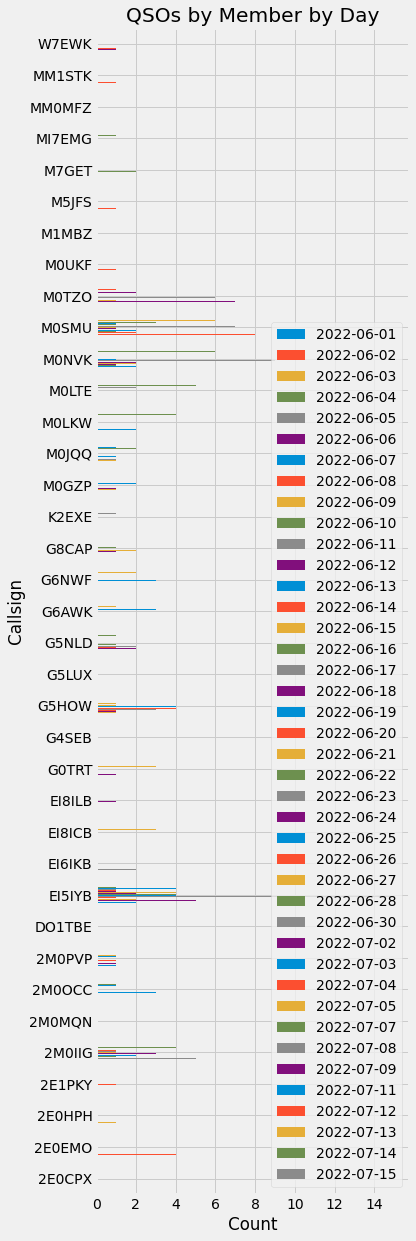

In [33]:
with pyplot.style.context(('fivethirtyeight')):
    daybyday = dfcleanalised[['UTC', 'Base Your Callsign', 'Base Their Callsign']]
    daybyday = daybyday.set_index('UTC')
    daybyday = daybyday.groupby(['Base Your Callsign', daybyday.index.date]).count()['Base Their Callsign'].unstack().plot.barh(figsize=(5,20))
    daybyday.set_xlabel('Count')
    daybyday.set_title('QSOs by Member by Day')
    daybyday.set_ylabel('Callsign')
    daybyday.xaxis.set_major_locator(MaxNLocator(integer=True))

### Most QSOs in a Day by a Callsign

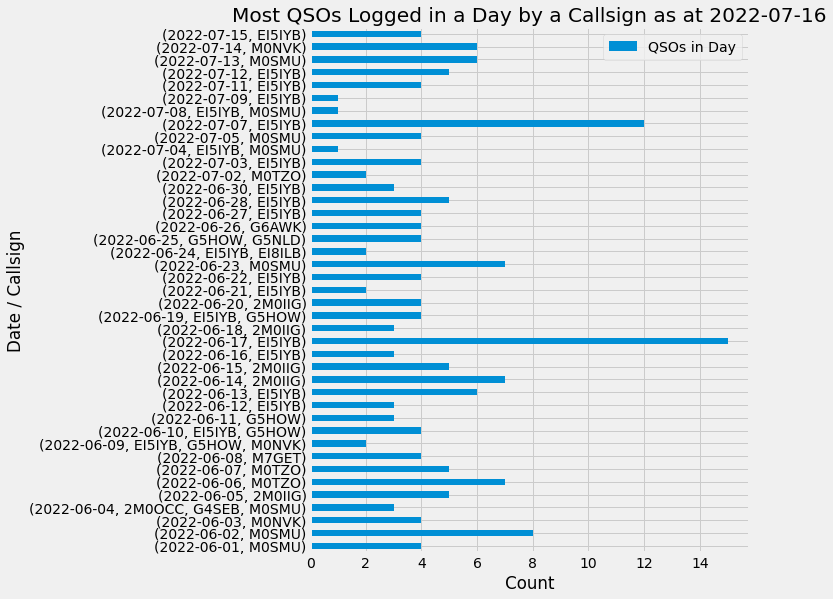

In [34]:
with pyplot.style.context(('fivethirtyeight')):
    qsomax = dfcleanalised[['UTC', 'Base Your Callsign', 'Base Their Callsign']]
    qsomax = qsomax.set_index('UTC')
    qsomax = qsomax.groupby([qsomax.index.date,'Base Your Callsign'])['Base Their Callsign'].count().unstack()
    qsomax['Max'] = qsomax.idxmax(axis=1)
    mostqsosperday = pd.DataFrame(columns=('Callsign', 'QSOs in Day'))
    for index, row in qsomax.iterrows():
        callsign = []
        for i in range(len(qsomax.columns)):
            if row[i] == row[row['Max']]:
                callsign.append(row.index[i])
        mostqsosperday.loc[index] = [", ".join(callsign), row[row['Max']]]
    mostqsosperday = mostqsosperday.set_index(['Callsign'], append=True)
    mostqsosperdayt = mostqsosperday
    mostqsosperday = mostqsosperday.plot(kind='barh', figsize=(7,9))
    mostqsosperday.set_xlabel('Count')
    mostqsosperday.set_title('Most QSOs Logged in a Day by a Callsign as at ' + today)
    mostqsosperday.set_ylabel('Date / Callsign')
    mostqsosperday.xaxis.set_major_locator(MaxNLocator(integer=True))
    if 'COLAB_GPU' not in os.environ:
        mostqsosperday.figure.savefig('images/mostqsosperday.png', bbox_inches='tight')
#mostqsosperdayt

## Stats by Week

### QSOs logged by week

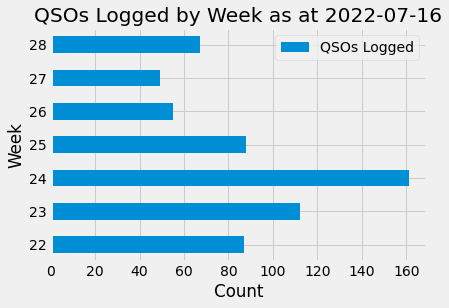

In [35]:
with pyplot.style.context(('fivethirtyeight')):
    weekbyweek = dfcleanalised[['UTC', 'Base Your Callsign']]
    weekbyweek = weekbyweek.set_index('UTC')
    weekbyweek = weekbyweek.groupby(weekbyweek.index.isocalendar().week)['Base Your Callsign'].count().plot.barh()
    weekbyweek.set_xlabel('Count')
    weekbyweek.set_title('QSOs Logged by Week as at ' + today)
    weekbyweek.set_ylabel('Week')
    weekbyweek.xaxis.set_major_locator(MaxNLocator(integer=True))
    weekbyweek.legend(['QSOs Logged'])
    if 'COLAB_GPU' not in os.environ:
        weekbyweek.figure.savefig('images/qsosbyweek.png', bbox_inches='tight')
# weekbyweekt = dfcleanalised[['UTC', 'Base Your Callsign']].set_index('UTC')
# weekbyweekt = weekbyweekt.groupby(weekbyweekt.index.isocalendar().week)['Base Your Callsign'].count()
# weekbyweekt

### Most QSOs in a Week by a Callsign

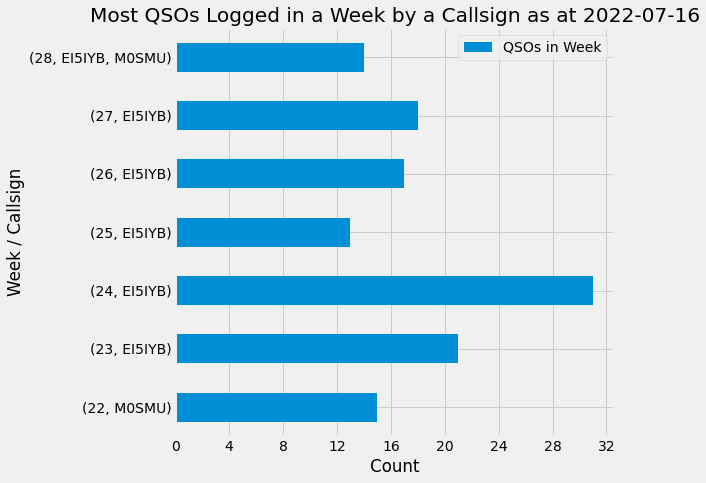

In [36]:
with pyplot.style.context(('fivethirtyeight')):
    qsomax = dfcleanalised[['UTC', 'Base Your Callsign', 'Base Their Callsign']]
    qsomax = qsomax.set_index('UTC')
    qsomax = qsomax.groupby([qsomax.index.isocalendar().week,'Base Your Callsign'])['Base Their Callsign'].count().unstack()
    qsomax['Max'] = qsomax.idxmax(axis=1)
    mostqsosperweek = pd.DataFrame(columns=('Callsign', 'QSOs in Week'))
    for index, row in qsomax.iterrows():
        callsign = []
        for i in range(len(qsomax.columns)):
            if row[i] == row[row['Max']]:
                callsign.append(row.index[i])
        mostqsosperweek.loc[index] = [", ".join(callsign), row[row['Max']]]
    mostqsosperweekt = mostqsosperweek.set_index(['Callsign'], append=True)
    mostqsosperweek = mostqsosperweek.set_index(['Callsign'], append=True).plot(kind='barh', figsize=(7,7))
    mostqsosperweek.set_xlabel('Count')
    mostqsosperweek.set_title('Most QSOs Logged in a Week by a Callsign as at ' + today)
    mostqsosperweek.set_ylabel('Week / Callsign')
    mostqsosperweek.xaxis.set_major_locator(MaxNLocator(integer=True))
    if 'COLAB_GPU' not in os.environ:
        mostqsosperweek.figure.savefig('images/mostqsosperweek.png', bbox_inches='tight')
# mostqsosperweekt

## By Month

### Most QSOs in a month

UTC
6    490
7    129
Name: Base Your Callsign, dtype: int64

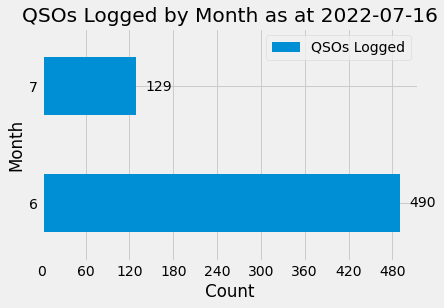

In [37]:
with pyplot.style.context(('fivethirtyeight')):
    monthbymonth = dfcleanalised[['UTC', 'Base Your Callsign']]
    monthbymonth = monthbymonth.set_index('UTC')
    monthbymonth = monthbymonth.groupby(monthbymonth.index.month)['Base Your Callsign'].count().plot.barh()
    monthbymonth.set_xlabel('Count')
    monthbymonth.set_title('QSOs Logged by Month as at ' + today)
    monthbymonth.set_ylabel('Month')
    monthbymonth.xaxis.set_major_locator(MaxNLocator(integer=True))
    monthbymonth.bar_label(monthbymonth.containers[0], label_type='edge', padding=10, fmt='%d')
    monthbymonth.legend(['QSOs Logged'])
    if 'COLAB_GPU' not in os.environ:
        monthbymonth.figure.savefig('images/qsosbymonth.png', bbox_inches='tight')
monthbymontht = dfcleanalised[['UTC', 'Base Your Callsign']].set_index('UTC')
monthbymontht = monthbymontht.groupby(monthbymontht.index.month)['Base Your Callsign'].count()
monthbymontht

### Most QSOs in a month by a member

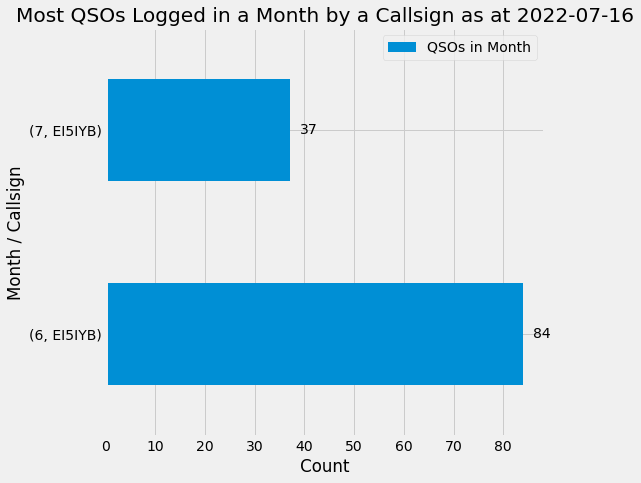

In [38]:
with pyplot.style.context(('fivethirtyeight')):
    qsomonthmax = dfcleanalised[['UTC', 'Base Your Callsign', 'Base Their Callsign']]
    qsomonthmax = qsomonthmax.set_index('UTC')
    qsomonthmax = qsomonthmax.groupby([qsomonthmax.index.month,'Base Your Callsign'])['Base Their Callsign'].count().unstack()
    qsomonthmax['Max'] = qsomonthmax.idxmax(axis=1)
    mostqsospermonth = pd.DataFrame(columns=('Callsign', 'QSOs in Month'))
    for index, row in qsomonthmax.iterrows():
        callsign = []
        for i in range(len(qsomonthmax.columns)):
            if row[i] == row[row['Max']]:
                callsign.append(row.index[i])
        mostqsospermonth.loc[index] = [", ".join(callsign), row[row['Max']]]
    mostqsospermontht = mostqsospermonth.set_index(['Callsign'], append=True)
    mostqsospermonth = mostqsospermonth.set_index(['Callsign'], append=True).plot(kind='barh', figsize=(7,7))
    mostqsospermonth.set_xlabel('Count')
    mostqsospermonth.set_title('Most QSOs Logged in a Month by a Callsign as at ' + today)
    mostqsospermonth.bar_label(mostqsospermonth.containers[0], label_type='edge', padding=10, fmt='%d')
    mostqsospermonth.set_ylabel('Month / Callsign')
    mostqsospermonth.xaxis.set_major_locator(MaxNLocator(integer=True))
    if 'COLAB_GPU' not in os.environ:
        mostqsospermonth.figure.savefig('images/mostqsospermonth.png', bbox_inches='tight')
# mostqsospermontht

## Distances and Grids


### Most Grids worked

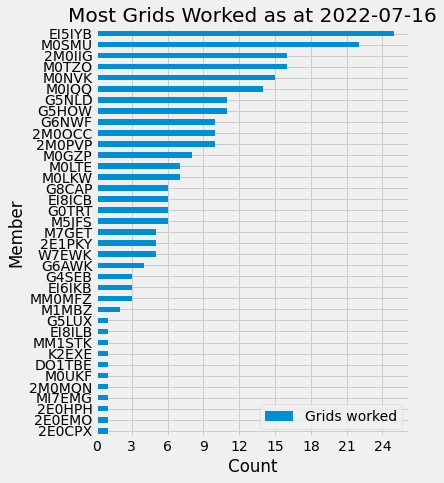

In [39]:
with pyplot.style.context(('fivethirtyeight')):
    dfcleanalised['RecGrid'] = dfcleanalised['Locator Received'].str[:4].str.upper()
    mostgridsworked = dfcleanalised[['Base Your Callsign', 'RecGrid']].drop_duplicates()
    mostgridsworked = mostgridsworked[['Base Your Callsign', 'RecGrid']].groupby('Base Your Callsign').count().sort_values(by='RecGrid').plot(kind='barh', figsize=(5,7))
    mostgridsworked.set_xlabel('Count')
    mostgridsworked.set_title('Most Grids Worked as at ' + today)
    mostgridsworked.set_ylabel('Member')
    mostgridsworked.xaxis.set_major_locator(MaxNLocator(integer=True))
    mostgridsworked.legend(['Grids worked'])
    if 'COLAB_GPU' not in os.environ:
        mostgridsworked.figure.savefig('images/mostgridsworked.png', bbox_inches='tight')
# mostgridsworkedt = dfcleanalised[['Base Your Callsign','RecGrid']][dfcleanalised['Base Your Callsign']=='EI5IYB'].drop_duplicates()
# mostgridsworkedt

### Activated most grids

,Base Your Callsign,SentGrid
15,EI5IYB,IO63
493,EI5IYB,IO52
511,EI5IYB,IO41
512,EI5IYB,IO42
572,EI5IYB,IO51
607,EI5IYB,IO62


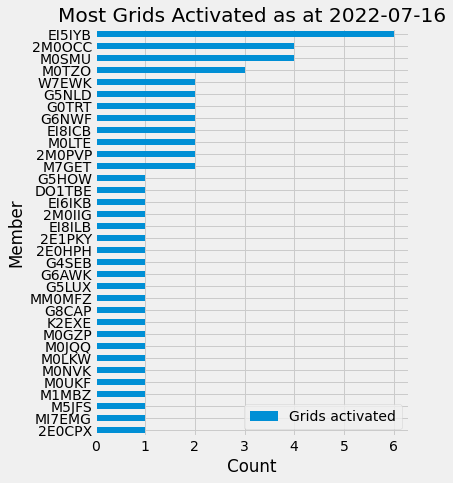

In [40]:
def stripgrids(grid):
    if grid[:1].isalpha():
        return (grid)
    else:
        return (np.NaN)
with pyplot.style.context(('fivethirtyeight')):
    dfcleanalised['SentGrid'] = dfcleanalised['Locator Sent'].str[:4].str.upper().str.strip().apply(stripgrids)
    mostgridsact = dfcleanalised[['Base Your Callsign', 'SentGrid']].dropna().drop_duplicates()
    mostgridsact = mostgridsact[['Base Your Callsign', 'SentGrid']].groupby('Base Your Callsign').count().sort_values(by='SentGrid').plot(kind='barh', figsize=(5,7))
    mostgridsact.set_xlabel('Count')
    mostgridsact.set_title('Most Grids Activated as at ' + today)
    mostgridsact.set_ylabel('Member')
    mostgridsact.xaxis.set_major_locator(MaxNLocator(integer=True))
    mostgridsact.legend(['Grids activated'])
    if 'COLAB_GPU' not in os.environ:
        mostgridsact.figure.savefig('images/mostgridsactivated.png', bbox_inches='tight')
mostgridsactt = dfcleanalised[['Base Your Callsign','SentGrid']][dfcleanalised['Base Your Callsign']=='EI5IYB'].dropna().drop_duplicates()
mostgridsactt

### Most worked pair of members

Definition: QSOs on different bands / modes between two members

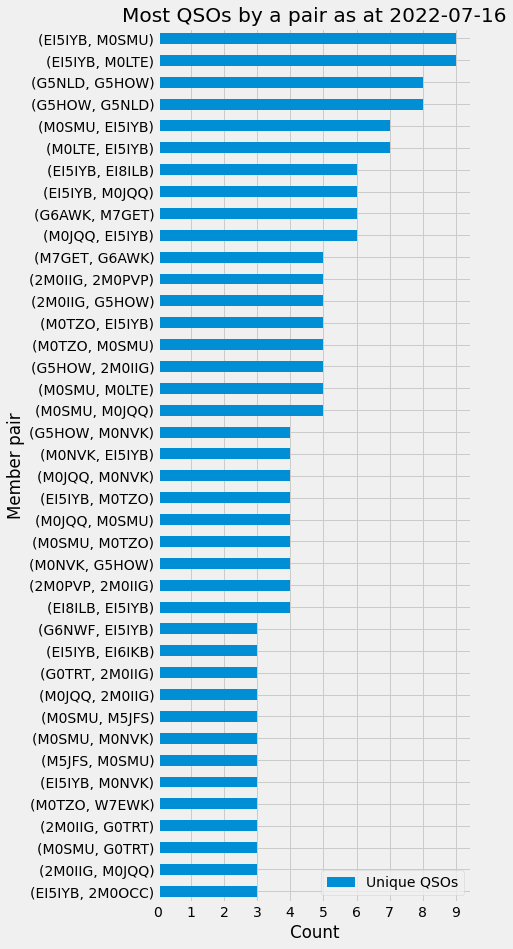

In [41]:
with pyplot.style.context(('fivethirtyeight')):
    pairsworked = dfcleanalised[['Base Your Callsign', 'Base Their Callsign', 'Band', 'Mode']].drop_duplicates()
    pairsworked = pairsworked.groupby(['Base Your Callsign', 'Base Their Callsign'])[['Band', 'Mode']].count().sort_values('Band')
    pairsworkedplot = pairsworked[pairsworked['Band']>2].plot.barh(y='Band', figsize=(5, 15))
    pairsworkedplot.set_xlabel('Count')
    pairsworkedplot.set_title('Most QSOs by a pair as at ' + today)
    pairsworkedplot.set_ylabel('Member pair')
    pairsworkedplot.xaxis.set_major_locator(MaxNLocator(integer=True))
    pairsworkedplot.legend(['Unique QSOs'])
    if 'COLAB_GPU' not in os.environ:
        pairsworkedplot.figure.savefig('images/pairsqsos.png', bbox_inches='tight')

### Furthest QSOs

Let's rank QSOs by distance

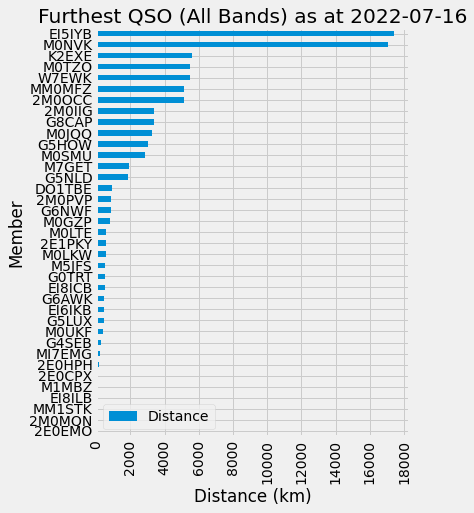

In [42]:
def qsodistance(sent, rec):
    slist = sent.split(', ')
    rlist = rec.split(', ')

    if slist[0][:2].isnumeric():
        # return(float(slist[0]) - float(slist[1]))
        distance = calculate_distance(
            mh.to_maiden(float(slist[0]), float(slist[1]), precision=4),
            mh.to_maiden(float(rlist[0]), float(rlist[1]), precision=4)
            )
        return(distance)
    elif sent[:2].isalpha():
        if rec[:2].isalpha():
            #return ('Yarp')
            return (calculate_distance(sent[:6], rec[:6]))
        return(0)
    else:
        return (0)
furthestqsos = dfcleanalised[['UTC', 'Your Callsign', 'Their Callsign', 'Base Your Callsign', 'Base Their Callsign', 'Band', 'Mode', 'Locator Sent', 'Locator Received']].copy()
furthestqsos['Distance'] = furthestqsos.apply(lambda x: qsodistance(x['Locator Sent'], x['Locator Received']), axis=1)
with pyplot.style.context(('fivethirtyeight')):
    furthestqsos = furthestqsos[['Distance', 'Base Your Callsign']].groupby('Base Your Callsign').max().sort_values(by='Distance').plot(y='Distance', kind='barh', figsize=(5,7))
    furthestqsos.set_title('Furthest QSO (All Bands) as at ' + today)
    furthestqsos.set_xlabel('Distance (km)')
    furthestqsos.set_ylabel('Member')
    furthestqsos.xaxis.set_tick_params(rotation=90)
    furthestqsos.xaxis.set_major_locator(MaxNLocator(integer=True))
    if 'COLAB_GPU' not in os.environ:
        furthestqsos.figure.savefig('images/furthestqsos.png', bbox_inches='tight')

### Furthest QSO (RF Only)

We filter out all Internet / Discord and Digital Voice

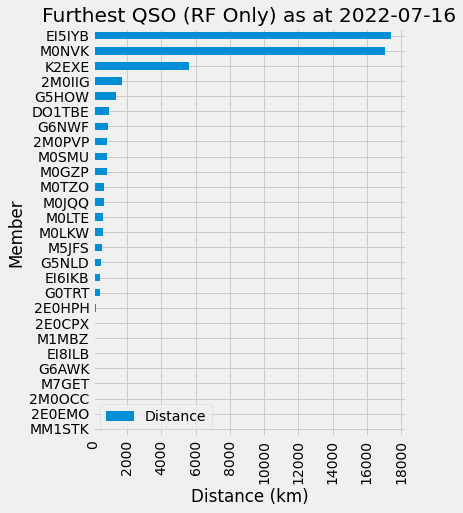

In [43]:
def qsodistance(sent, rec):
    slist = sent.split(', ')
    rlist = rec.split(', ')

    if slist[0][:2].isnumeric():
        # return(float(slist[0]) - float(slist[1]))
        distance = calculate_distance(
            mh.to_maiden(float(slist[0]), float(slist[1]), precision=4),
            mh.to_maiden(float(rlist[0]), float(rlist[1]), precision=4)
            )
        return(distance)
    elif sent[:2].isalpha():
        if rec[:2].isalpha():
            #return ('Yarp')
            return (calculate_distance(sent[:6], rec[:6]))
        return(0)
    else:
        return (0)
furthestrfqsos = dfcleanalised[['UTC', 'Your Callsign', 'Their Callsign', 'Base Your Callsign', 
                                'Base Their Callsign', 'Band', 'Mode', 'Locator Sent', 
                                'Locator Received']][(dfcleanalised['Mode'] != 'Digital Voice') & (~dfcleanalised['Band'].isin(['Internet', 'Discord']))].copy()
furthestrfqsos['Distance'] = furthestrfqsos.apply(lambda x: qsodistance(x['Locator Sent'], x['Locator Received']), axis=1)
with pyplot.style.context(('fivethirtyeight')):
    furthestrfqsosplot = furthestrfqsos[['Distance', 'Base Your Callsign']].groupby('Base Your Callsign').max().sort_values(by='Distance').plot(y='Distance', kind='barh', figsize=(5,7))
    furthestrfqsosplot.set_title('Furthest QSO (RF Only) as at ' + today)
    furthestrfqsosplot.set_xlabel('Distance (km)')
    furthestrfqsosplot.set_ylabel('Member')
    furthestrfqsosplot.xaxis.set_tick_params(rotation=90)
    furthestrfqsosplot.xaxis.set_major_locator(MaxNLocator(integer=True))
    if 'COLAB_GPU' not in os.environ:
        furthestrfqsosplot.figure.savefig('images/furthestrfqsos.png', bbox_inches='tight')

### Cumulative QSO distance (All Bands)

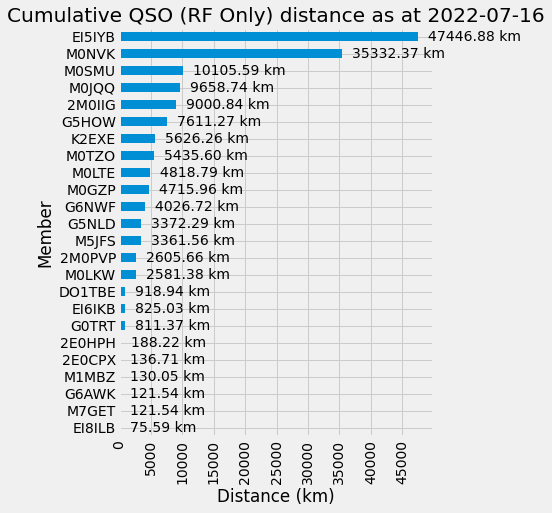

In [44]:
totalqsodistance = furthestrfqsos[['Distance', 'Base Your Callsign']].groupby('Base Your Callsign').sum().sort_values(by='Distance')
totalqsodistance = totalqsodistance[totalqsodistance['Distance']>0]
with pyplot.style.context(('fivethirtyeight')):
    totalqsodistanceplot = totalqsodistance.plot(y='Distance', kind='barh', figsize=(5,7), legend=False)
    totalqsodistanceplot.set_title('Cumulative QSO (RF Only) distance as at ' + today)
    totalqsodistanceplot.set_xlabel('Distance (km)')
    totalqsodistanceplot.set_ylabel('Member')
    totalqsodistanceplot.xaxis.set_tick_params(rotation=90)
    totalqsodistanceplot.xaxis.set_major_locator(MaxNLocator(integer=True))
    totalqsodistanceplot.bar_label(totalqsodistanceplot.containers[0], label_type='edge', padding=10, fmt='%.2f km')
    if 'COLAB_GPU' not in os.environ:
        totalqsodistanceplot.figure.savefig('images/cumulativerfqsos.png', bbox_inches='tight')

## Experiments

### IOTA Map

In [45]:
with open('response.json') as json_file:
    iotaislands = json.load(json_file)
for i in iotaislands['content']:
    if i['refno'] == 'AF-114':
        print ('IOTA Ref:', i['refno'], 'Name:', i['name'], 'DXCC:', i['dxcc_num'])
        for j in i['sub_groups']:
            print(j['subname'])
            for k in j['islands']:
                print (k)
dfcleanalised['Locator Sent'] = dfcleanalised['Locator Sent'].str.upper()
dfcleanalised['Locator Received'] = dfcleanalised['Locator Received'].str.upper()
iotalocators = dfcleanalised[['Locator Sent', 'Locator Received', 'Base Your Callsign', 'Base Their Callsign', 'SOTA / IOAT / Sat / Network information']][dfcleanalised['SOTA / IOAT / Sat / Network information'].str.startswith('IOTA')]
iotalocators = iotalocators['SOTA / IOAT / Sat / Network information'].drop_duplicates()
iotalocators = iotalocators.str.split()
iotalocators

IOTA Ref: AF-114 Name: Halaib Triangle group DXCC: 466
[No sub-group]
{'id': '12333', 'island_name': 'Dibia', 'comment': '', 'excluded': '0'}
{'id': '12332', 'island_name': 'Siyal Islands', 'comment': '', 'excluded': '0'}
Ruwabil Islands

{'id': '12331', 'island_name': 'Ruwabil Islands', 'comment': '', 'excluded': '0'}
Siyal Islands



300                                       [IOTA, EU-115]
308                              [IOTA, EU-115, Ireland]
448                 [IOTA, EU-115, Ireland, |, EchoLink]
502    [IOTA, EU-115, Ireland, |, Zello, to, Southern...
Name: SOTA / IOAT / Sat / Network information, dtype: object

### SOTA Map 2

This time we:
1. Get all the SOTA locators in a list.
1. Iterate the list and
   1. Add the summit to a layergroup
   2. Add all the associated QSOs to the layergroup (chaser marker and one line per QSO. i.e. check if its already shown first)
   3. Add the layergroup to the map
1. Add a layercontrol

In [46]:
sotalocators1 = dfcleanalised[['UTC', 'Locator Sent', 'Locator Received', 'Base Your Callsign', 'Base Their Callsign', 'Band', 'Mode', 'SOTA / IOAT / Sat / Network information']][dfcleanalised['SOTA / IOAT / Sat / Network information'].str.contains('\-', regex=True)]
sotalocators1 = sotalocators1[sotalocators1['SOTA / IOAT / Sat / Network information'].str.contains('/', regex=True)].drop_duplicates()
sotalocators1 = sotalocators1[sotalocators1['SOTA / IOAT / Sat / Network information'].str.contains('HEMA', regex=True)==False]
sotalocators1['Distance'] = sotalocators1.apply(lambda row: calculate_distance(row['Locator Sent'], row['Locator Received']), axis=1)
sotalist = sotalocators1['SOTA / IOAT / Sat / Network information'].unique()
sotamap2 = Map(basemap=basemaps.Stamen.Terrain, center = [54, -2], zoom = 5, scroll_wheel_zoom=True)
layerlist = list()
for summit in sotalist:
    url = ("https://api2.sota.org.uk/api/summits/" + summit)
    sotasummit = requests.request("GET", url)
    response = sotasummit.json()
    qsomarks = list()
    qsolocs = list()
    markermessage = HTML(value="%s - %s<br />%s"%(response['name'], response['summitCode'], response['locator']))
    marker = Marker(location=(response['latitude'], response['longitude']), draggable=False, icon=icon1, popup=markermessage)
    qsomarks.append(marker)
    for sotaqso in sotalocators1[sotalocators1['SOTA / IOAT / Sat / Network information'] == summit].iterrows():
        # print (sotaqso[1]['Locator Sent'].upper()," : ", response['locator'].upper()) 
        # print (sotaqso[1]['Locator Sent'].upper().strip() == response['locator'].upper().strip())
        if sotaqso[1]['Locator Sent'].upper().strip() == response['locator'].upper().strip():
            if sotaqso[1]['Locator Received'].upper().strip() not in qsolocs:
                # we are the activator and we haven't logged this locator yet, so we want a marker for the chaser and to log that we have seen that locator
                markermessage = HTML(value="%s (%s)"%(sotaqso[1]['Base Their Callsign'], sotaqso[1]['Locator Received']))
                marker = Marker(draggable=False, icon=icon3, location=(mh.to_location(sotaqso[1]['Locator Received'], center=True)[0],
                                                                       mh.to_location(sotaqso[1]['Locator Received'], center=True)[1]), popup=markermessage)
                qsomarks.append(marker)
                qsolocs.append(sotaqso[1]['Locator Received'].upper().strip())
                qsoline = [[mh.to_location(sotaqso[1]['Locator Received'], center=True)[0],
                            mh.to_location(sotaqso[1]['Locator Received'], center=True)[1]], 
                           [mh.to_location(response['locator'], center=True)[0],
                            mh.to_location(response['locator'], center=True)[1]]]
                message = HTML(value="%s > %s<br />(%s > %s)<br />Distance %skm<br />%s - %s"%(sotaqso[1]['Base Your Callsign'],
                          sotaqso[1]['Base Their Callsign'], sotaqso[1]['Locator Received'], response['locator'], round(sotaqso[1]['Distance'], 2), sotaqso[1]['Band'], sotaqso[1]['Mode']))
                linelayer = Polyline(locations=qsoline, color='green', fill=False, popup=message)
                qsomarks.append(linelayer)
        if sotaqso[1]['Locator Received'].upper().strip() == response['locator'].upper().strip():
            if sotaqso[1]['Locator Sent'].upper().strip() not in qsolocs:
                # we are the chaser and we haven't logged this locator yet, so we want a marker for the chaser and to log that we have seen that locator
                markermessage = HTML(value="%s (%s)"%(sotaqso[1]['Base Your Callsign'], sotaqso[1]['Locator Sent']))
                marker = Marker(draggable=False, icon=icon3, location=(mh.to_location(sotaqso[1]['Locator Sent'], center=True)[0],
                                                                       mh.to_location(sotaqso[1]['Locator Sent'], center=True)[1]), popup=markermessage)
                qsomarks.append(marker)
                qsolocs.append(sotaqso[1]['Locator Sent'].upper().strip())
                qsoline = [[mh.to_location(sotaqso[1]['Locator Sent'], center=True)[0],
                            mh.to_location(sotaqso[1]['Locator Sent'], center=True)[1]], 
                           [mh.to_location(response['locator'], center=True)[0],
                            mh.to_location(response['locator'], center=True)[1]]]
                message = HTML(value="%s > %s<br />(%s > %s)<br />Distance %skm<br />%s - %s"%(sotaqso[1]['Base Their Callsign'],
                          sotaqso[1]['Base Your Callsign'], sotaqso[1]['Locator Sent'], response['locator'], round(sotaqso[1]['Distance'], 2), sotaqso[1]['Band'], sotaqso[1]['Mode']))
                linelayer = Polyline(locations=qsoline, color='green', fill=False, popup=message)
                qsomarks.append(linelayer)      
    layerlist.append(LayerGroup(layers=qsomarks, name=summit))
for lg in layerlist:
    sotamap2.add_layer(lg)
sotamap2.layout.height='700px'
sotamap2.add_control(LayersControl())
if 'COLAB_GPU' not in os.environ:
    sotamap2.save('maps/SOTA2.html', title='SOTA Map')
sotamap2

Map(center=[54, -2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

### Activated Squares Map

We get all the squares where a QSO has originated (length 4, truncate anything longer and drop duplicates), then we draw a square for each unique square,
coloured based on number of QSOs and add Text with the name of each square

In [47]:
from ipyleaflet import Rectangle, WidgetControl

def handle_mouseover(rect,ghtml):
    def callback(*args, **kwargs):
       #print('OVER: ', rect.name, rect)
       rect.color='red'
       ghtml.value = '''
       <h2><b>%s</b></h2>
       '''%(rect.name)
    return callback

def handle_mouseout(rect,ghtml):
    def callback(*args, **kwargs):
       #print('OUT: ', rect.name, rect)
       rect.color='blue'
       ghtml.value='''Hover over grids'''
    return callback

dfcleanalised['Grids'] = dfcleanalised['Locator Sent'].str.slice(0,4)
grids = dfcleanalised.groupby('Grids')['Base Your Callsign'].count().drop(labels='').sort_values()
tobedropped = list()
for grid in grids.index:
    if grid[0].isdigit():
        tobedropped.append(grid)
grids = grids.drop(labels=tobedropped)
grids = grids.to_frame()
lats = list()
longs = list()
for grid in grids.index:
    loc = mh.to_location(grid, center=True)
    lats.append(loc[0])
    longs.append(loc[1])
grids = grids.assign(Latitude = lats)
grids = grids.assign(Longitude = longs)
gridhtml = HTML('''Hover over grids''')
gridhtml.layout.margin = '0px 20px 20px 20px'
gridcontrol = WidgetControl(widget=gridhtml, position = 'topright')
gridmap = Map(basemap=basemaps.Stamen.Terrain, center = [54, -2], zoom = 5, scroll_wheel_zoom=True, touch_zoom=False)
gridmap.add_control(gridcontrol)
for grid in grids.iterrows():
    message = HTML(value="%s"%(grid[0]))
    rectangle = Rectangle(bounds=((grid[1][1]-0.5, grid[1][2]-1), (grid[1][1]+0.5, grid[1][2]+1)), popup=message, name=grid[0])
    rectangle.color='blue'
    rectangle.stroke=False
    rectangle.fill_opacity=0.3
    rectangle.on_mouseover(handle_mouseover(rectangle, gridhtml))
    rectangle.on_mouseout(handle_mouseout(rectangle, gridhtml))
    gridmap.add_layer(rectangle)
gridmap.layout.height='700px'
if 'COLAB_GPU' not in os.environ:
    gridmap.save('maps/gridsactivated.html', title='Grids Activated by Members Map')
gridmap

Map(center=[54, -2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…